# Predicting Customer Churn for Ride-Sharing Company

A ride-sharing company is interested in predicting rider retention. To help explore this question, they provided a sample dataset of a cohort of users who signed up for an account in January 2014. The data was pulled on July 1, 2014. The company considers a user retained if they were “active” (i.e. took a trip) in the preceding 30 days (from the day the data was pulled). The task is to build a model to distinguish customers who are likely to churn based on available data and propose actionable plans to reduce churn.

In [1]:
# imports
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
import autoreload

## 1. Load data

In [1]:
# read ride data
from load_data import load_csv_data

ride_train = load_csv_data(name='churn_train.csv')
ride_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


## 2. Prep data

The data was made available in two csv documents (separate documents with the training and test sets). The training set contains 40,000 entries and 12 columns. The following columns need work:
* The last_trip_date and signup_date columns are strings and have to be converted to datetime. Also, I need to create Boolean not_active column from these dates, which will be the target variable.
* There are 162 missing ratings by drivers, 6,528 missing ratings by riders, and 319 missing phone numbers. I decided to remove rows with missing phone numbers and impute ratings using the mode of all values.
* There are two categorical features, city and phone. They need to be encoded for some of the estimators (one hot encoding).
* Numerical features will need to be standardized for some models using StandardScaler.

Data cleaning tasks involving datetime transformations will regrettably have to be done outside a proper pipeline. Since Scikit-Learn operates with homogeneous numpy arrays and pandas are heterogeneous dtypes, datetimes cannot be stored and manipulated natively in numpy arrays.

In [3]:
# convert dates into datetime 
from cleaning_dates import date_transformer

columns = ['last_trip_date', 'signup_date']

ride_train = date_transformer(ride_train, columns)
ride_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null datetime64[ns]
phone                     39681 non-null object
signup_date               40000 non-null datetime64[ns]
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.4+ MB


In [4]:
# create label df with not_active column
from cleaning_dates import create_not_active

ride_label = create_not_active(ride_train, 'last_trip_date', 'not_active')

Here I am setting up a proper transformation pipeline for the rest of the data preparation/cleaning tasks. I will use different pipelines for distance-based models (such as SVM and kNN, which require scaling) and ensemble methods. Pipelines also make it easy to adjust transformation methods at a later stage to help find the best-performing model.

In [5]:
# set up pipeline for SVM and kNN (both need scaling)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from cleaning_custom import DataFrameSelector, CustomLabelBinarizer
from sklearn.pipeline import FeatureUnion

num_attribs = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver','avg_surge', 'surge_pct',\
               'trips_in_first_30_days', 'weekday_pct']
cat_attribs = ['city', 'phone']


num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="most_frequent")), # used mode for ensembles, drop for SVM
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CustomLabelBinarizer(cat_attribs)),
    ])

# put numerical and categorical pipeline together
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline), 
        ("cat_pipeline", cat_pipeline),
    ])

# transform data
ride_prepared = full_pipeline.fit_transform(ride_train)

In [ ]:
# set x_train and y_train for cross-validation
x_train = ride_prepared
y_train = ride_label

## First Models

I shortlisted the following machine learning models for the classification task:

* Linear SVM
* kNN
* SGD Classifier
* Ensemble classifiers (bagged trees, random forest, adaboost, stochastic gradient boost)
* SVM (other kernels).

In [8]:
# Support Vector Machine - linear
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

# fit a SVM model to the data
svc_clf = LinearSVC()
svc_clf.fit(x_train, y_train)

# evaluate
svc_scores = cross_val_score(svc_clf, x_train, y_train, scoring='roc_auc', cv=skf)
print(svc_clf.__class__.__name__)
print("Average scores: ", svc_scores.mean())
print("Standard Deviation of scores: ", svc_scores.std())

LinearSVC
Average scores:  0.7424938161825312
Standard Deviation of scores:  0.006157293960869648


In [36]:
# k-Nearest Neighbor 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

# fit a k-nearest neighbor model to the data
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_train)

# evaluate
knn_scores = cross_val_score(knn_clf, x_train, y_train, scoring='roc_auc', cv=skf)
print(knn_clf.__class__.__name__)
print("Average scores: ", knn_scores.mean())
print("Standard Deviation of scores: ", knn_scores.std())

KNeighborsClassifier
Average scores:  0.781875912884089
Standard Deviation of scores:  0.0028988900803399303


k-Nearest Neighbor did better than the linear Support Vector Machine, which is both surprising (kNN usually doesn't do well with more than five features) and unsurprising (it is probably not a linear relationship between the features and the target variable). I ran SVM with nonlinear kernels (in another notebook) and got much better scores (an AUC of 0.82 with a standard deviation comparable to kNN), so I will only do parameter tuning on SVMs.

# Ensemble Models

For the ensemble models, I did not scale the data. With the sheer exception of the Stochastic Gradient Descent Classifer, they all achieved an over 0.80 AUC score. For brevity, I only tuned the parameters of the Stochastic Gradient Boosted Decision Trees and the Random Forests, since the latter may provide some insight into the customer characteristics that predict churn through the feature_importances attribute.

In [7]:
# set up pipeline for ensembles
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from cleaning_custom import DataFrameSelector, CustomLabelBinarizer
from sklearn.pipeline import FeatureUnion

num_attribs = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver','avg_surge', 'surge_pct',\
               'trips_in_first_30_days', 'weekday_pct']
cat_attribs = ['city', 'phone']


num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="most_frequent")), # used mode for ensembles, drop for SVM
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CustomLabelBinarizer(cat_attribs)),
    ])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline), 
        ("cat_pipeline", cat_pipeline),
    ])

ride_prepared_noscale = full_pipeline.fit_transform(ride_train)

# set X_train and X_test for cross-validation
x_train1 = ride_prepared_noscale
y_train = ride_label

In [12]:
# Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

# fit an SGD classifier model to the data
sgd_clf = SGDClassifier(random_state=1)
sgd_clf.fit(x_train1, y_train)

# evaluate
sgd_scores = cross_val_score(sgd_clf, x_train1, y_train, scoring='roc_auc', cv=skf)
print(sgd_clf.__class__.__name__)
print("Average SGD scores: ", sgd_scores.mean())
print("Standard Deviation of SGD scores: ", sgd_scores.std())

SGDClassifier
Average SGD scores:  0.6636649993853246
Standard Deviation of SGD scores:  0.03098091622974281


In [13]:
# Bagged Decision Trees for Classification
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

seed = 1
cart = DecisionTreeClassifier()
num_trees = 100

btc_clf =  BaggingClassifier(base_estimator=cart, n_estimators=num_trees)
btc_clf.fit(x_train1, y_train)

# evaluate
btc_scores = cross_val_score(btc_clf, x_train1, y_train, scoring='roc_auc', cv=skf)
print(btc_clf.__class__.__name__)
print("Average scores: ", btc_scores.mean())
print("Standard Deviation of scores: ", btc_scores.std())

BaggingClassifier
Average scores:  0.8076228171889006
Standard Deviation of scores:  0.006061252584623839


In [10]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

num_trees = 100
max_features = 3

# fit random fortest to the data
rfc_clf = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
rfc_clf.fit(x_train1, y_train)

# evaluate
rfc_scores = cross_val_score(rfc_clf, x_train1, y_train, scoring='roc_auc', cv=skf)
print(rfc_clf.__class__.__name__)
print("Average scores: ", rfc_scores.mean())
print("Standard Deviation of scores: ", rfc_scores.std())

RandomForestClassifier
Average scores:  0.8073042319581699
Standard Deviation of scores:  0.004308292930064956


In [15]:
# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

seed = 1
num_trees = 30

# fit AdaBoost to data
abc_clf = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
abc_clf.fit(x_train1, y_train)

# evaluate
abc_scores = cross_val_score(abc_clf, x_train1, y_train, scoring='roc_auc', cv=skf)
print(abc_clf.__class__.__name__)
print("Average scores: ", abc_scores.mean())
print("Standard Deviation of scores: ", abc_scores.std())

AdaBoostClassifier
Average scores:  0.8369841958465413
Standard Deviation of scores:  0.004496452958254571


In [16]:
# Stochastic Gradient Boosting Classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5)

seed = 1
num_trees = 100

# fit model
gbc_clf = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
gbc_clf.fit(x_train1, y_train)

# evaluate
gbc_scores = cross_val_score(gbc_clf, x_train1, y_train, scoring='roc_auc', cv=skf)
print(gbc_clf.__class__.__name__)
print("Average scores: ", gbc_scores.mean())
print("Standard Deviation of scores: ", gbc_scores.std())

GradientBoostingClassifier
Average scores:  0.8454176932019102
Standard Deviation of scores:  0.002353485269052784


## Finetuning Parameters with GridSearch: SVM

For SVM, there are only two parameters to tune: C and gamma. (See here for an interactive demo on how they affect your classification: https://cs.stanford.edu/people/karpathy/svmjs/demo/) In another notebook I tried several kernels as well. A perfect classifier would have an AUC of 1.0, and random guessing will give you a 0.5. SVM with sigmoid actually does worse than random guessing at an AUC score of 0.45!

In [12]:
# find ideal C and gamma using GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC


Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
skf = StratifiedKFold(n_splits=5)
svm_clf = SVC(kernel='rbf')
svc_rand_search = RandomizedSearchCV(svm_clf, param_distributions=param_grid, scoring='roc_auc', cv=skf)

# fit the grid with data
svc_rand_search.fit(x_train, y_train)

# print best results
svc_rand_search.best_params_

{'C': 10, 'gamma': 0.1}

In [13]:
# SVM with ideal params - rbf kernel
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

# fit a SVM model to the data
svc_clf = SVC(kernel='rbf', C=10, gamma=0.1)
svc_clf.fit(x_train, y_train)

# evaluate
svc_scores = cross_val_score(svc_clf, x_train, y_train, scoring='roc_auc', cv=skf)
print(svc_clf.__class__.__name__)
print("Average scores: ", svc_scores.mean())
print("Standard Deviation of scores: ", svc_scores.std())

SVC
Average scores:  0.8181404511659209
Standard Deviation of scores:  0.00407412144734861


## Finetuning Parameters: Gradient Boosted Trees

Much like RandomForestClassifier, Gradient Boosted Trees has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown, such as max_depth, min_samples_leaf, etc.), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself (n_estimators). For more on hyperparameter tuning and gradient boosting: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [21]:
# find ideal GB params with random grid search
# tree params:
# max_features sqrt(30%-40% of 13) it should be 2
# max_depth 5-20
# min_samples_split 0.5%-2% of 40,000 (200, 400, 600, 800) or
# min_samples_leaf
# boosting params:
# learning_rate
# loss (deviance for classification)

# n_estimator (# of trees) keep it low first
# subsample 0.5, 0.8 - analytics vidhya
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

# create a parameter grid: map the parameter names to the values
param_grid = {'max_features': [1, 2],
              'max_depth': [2, 3, 5, 7, 10],
              'min_samples_leaf': [1, 2, 3, 5, 7, 10],
              'n_estimators': [100, 200],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
              'loss': ['deviance'],}

skf = StratifiedKFold(n_splits=10)

# instantiate the grid
gbc_rand_search = RandomizedSearchCV(GradientBoostingClassifier(warm_start=True), 
                                 param_distributions=param_grid, scoring='roc_auc', cv=skf, 
                                 n_iter=10, n_jobs=-1)
# fit the grid with data
gbc_rand_search.fit(x_train1, y_train)
# print best results
gbc_rand_search.best_params_

{'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 2,
 'min_samples_leaf': 10,
 'n_estimators': 200}

In [17]:
# GB with ideal params
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

# fit model
gbc_clf = GradientBoostingClassifier(learning_rate= 0.2,
                                     loss= 'deviance',
                                     max_depth= 5,
                                     max_features= 2,
                                     min_samples_leaf=10,
                                     n_estimators= 200)
gbc_clf.fit(x_train1, y_train)

# evaluate
gbc_scores = cross_val_score(gbc_clf, x_train1, y_train, scoring='roc_auc', cv=skf)
print(gbc_clf.__class__.__name__)
print("Average scores: ", gbc_scores.mean())
print("Standard Deviation of scores: ", gbc_scores.std())

GradientBoostingClassifier
Average scores:  0.8488039740196527
Standard Deviation of scores:  0.0040771913784986135


## Finetuning Parameters: Random Forest and Feature Importance

Since random forests tackle the high variance of bagged decision trees by randomly sampling not only the data but the features used to build the decision tree at each turn, they generally yield better results than bagged trees. Accordingly, I only ran grid search on random forests. For more on the model's hypermeters, see
https://medium.com/@taplapinger/tuning-a-random-forest-classifier-1b252d1dde92

I also looked at the most important features using random forest, which turned up little information. Churn shows linear relationship (positive correlation) with Android users and rides originating in "Astapor," but these features could possibly hide a confounding variable – income – as Android owners and residents of this area may have less disposable income. Churn also increases with surge percentages over 5% (unsurprising) and ride distances over 4 miles (again, these riders may be making expensive long-distance trips with a low enough frequency to qualify as 'churned' when churned is defined with a 30-day window).

In [10]:
# Random Forest parameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# create a parameter grid: map the parameter names to the values
param_grid = {'max_features': ['auto'],
              'n_estimators': [100, 200, 400, 600, 800, 1000],
              'max_depth': [2, 3, 5, 7, 10, 20, 30, 40, 50, 100],
              'min_samples_split': [200, 400, 600, 800],}

skf = StratifiedKFold(n_splits=10)

# instantiate the grid
rf_rand_search = RandomizedSearchCV(RandomForestClassifier(warm_start=True), 
                                 param_distributions=param_grid, scoring='roc_auc', cv=skf, 
                                 n_iter=100, n_jobs=-1)
# fit the grid with data
rf_rand_search.fit(x_train1, y_train)
# print best results
rf_rand_search.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_split': 200,
 'n_estimators': 400}

In [11]:
# random forest with ideal params
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

num_trees = 400
max_features = 'auto'
min_samples_split=200
max_depth=20

# fit random fortest to the data
rfc_clf = RandomForestClassifier(n_estimators=num_trees, max_features=max_features, 
                                 min_samples_split=min_samples_split, max_depth=max_depth)
rfc_clf.fit(x_train1, y_train)

# evaluate
rfc_scores = cross_val_score(rfc_clf, x_train1, y_train, scoring='roc_auc', cv=skf)
print(rfc_clf.__class__.__name__)
print("Average scores: ", rfc_scores.mean())
print("Standard Deviation of scores: ", rfc_scores.std())

RandomForestClassifier
Average scores:  0.8435702438689212
Standard Deviation of scores:  0.0041707778094541926


## Evaluating the Test Set

Since the differences between the AUC scores are so small, we cannot discount the possibility that Gradient Boosting only perfors better due to chance in the random sampling of the k-folds. (For more on this topic, see the excellent blog post: https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/). Instead of running a statistical significance test, here I opted for evaluating all three models on the exact same unseen test set.

In [9]:
# read in test dataset for SVM
from load_data import load_csv_data

ride_test = load_csv_data(name='churn_test.csv')

# convert dates into datetime 
from cleaning_dates import date_transformer

columns = ['last_trip_date', 'signup_date']

ride_test = date_transformer(ride_test, columns)

# create label df with not_active column
from cleaning_dates import create_not_active

ride_label_t = create_not_active(ride_test, 'last_trip_date', 'not_active')

# set up pipeline for SVM and kNN (both need scaling)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from cleaning_custom import DataFrameSelector, CustomLabelBinarizer
from sklearn.pipeline import FeatureUnion

num_attribs = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver','avg_surge', 'surge_pct',\
               'trips_in_first_30_days', 'weekday_pct']
cat_attribs = ['city', 'phone']


num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="most_frequent")), # used mode for ensembles, drop for SVM
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CustomLabelBinarizer(cat_attribs)),
    ])

# put numerical and categorical pipeline together
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline), 
        ("cat_pipeline", cat_pipeline),
    ])

# transform data
ride_test_prepared = full_pipeline.fit_transform(ride_test)

# set X_train and X_test for cross-validation
x_traint = ride_test_prepared
y_traint = ride_label_t

In [10]:
# run SVM
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

# fit a SVM model to the data
svc_clf = SVC(kernel='rbf', C=10, gamma=0.1)
svc_clf.fit(x_traint, y_traint)

# evaluate
svc_scores = cross_val_score(svc_clf, x_traint, y_traint, scoring='roc_auc', cv=skf)
print(svc_clf.__class__.__name__)
print("Average scores: ", svc_scores.mean())
print("Standard Deviation of scores: ", svc_scores.std())

SVC
Average scores:  0.8094650267160033
Standard Deviation of scores:  0.012716216850244667


In [6]:
# set up pipeline for ensembles
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from cleaning_custom import DataFrameSelector, CustomLabelBinarizer
from sklearn.pipeline import FeatureUnion

num_attribs = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver','avg_surge', 'surge_pct',\
               'trips_in_first_30_days', 'weekday_pct']
cat_attribs = ['city', 'phone']


num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="most_frequent")), # used mode for ensembles, drop for SVM
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CustomLabelBinarizer(cat_attribs)),
    ])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline), 
        ("cat_pipeline", cat_pipeline),
    ])

ride_test_prepared_noscale = full_pipeline.fit_transform(ride_test)

# set X_train and X_test for cross-validation
x_traint1 = ride_test_prepared_noscale
y_traint = ride_label_t

In [7]:
# run RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

num_trees = 400
max_features = 'auto'
min_samples_split=200
max_depth=20

# fit random fortest to the data
rfc_clf = RandomForestClassifier(n_estimators=num_trees, max_features=max_features, 
                                 min_samples_split=min_samples_split, max_depth=max_depth)
rfc_clf.fit(x_traint1, y_traint)

# evaluate
rfc_scores = cross_val_score(rfc_clf, x_traint1, y_traint, scoring='roc_auc', cv=skf)
print(rfc_clf.__class__.__name__)
print("Average scores: ", rfc_scores.mean())
print("Standard Deviation of scores: ", rfc_scores.std())

RandomForestClassifier
Average scores:  0.8305902177793995
Standard Deviation of scores:  0.01336479193392914


In [8]:
# run GB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

# fit model
gbc_clf = GradientBoostingClassifier(learning_rate= 0.2,
                                     loss= 'deviance',
                                     max_depth= 5,
                                     max_features= 2,
                                     min_samples_leaf=10,
                                     n_estimators= 200)
gbc_clf.fit(x_traint1, y_traint)

# evaluate
gbc_scores = cross_val_score(gbc_clf, x_traint1, y_traint, scoring='roc_auc', cv=skf)
print(gbc_clf.__class__.__name__)
print("Average scores: ", gbc_scores.mean())
print("Standard Deviation of scores: ", gbc_scores.std())

GradientBoostingClassifier
Average scores:  0.8312978387766107
Standard Deviation of scores:  0.01182994582764266


Gradient Boosting outperformed all three on both the average AUC scores and the standard deviation of the scores. The results can be seen on the plot below.

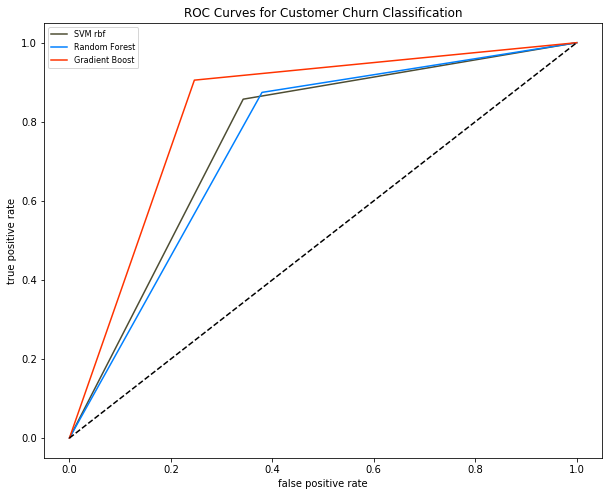

In [11]:
# plot all three
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

y_true = y_traint
y_score_svc = svc_clf.predict(x_traint)
y_score_rfc = rfc_clf.predict(x_traint1)
y_score_gbc = gbc_clf.predict(x_traint1)

fpr1,tpr1,thr1=roc_curve(y_true, y_score_svc)
fpr2,tpr2,thr2=roc_curve(y_true, y_score_rfc)
fpr3,tpr3,thr3=roc_curve(y_true, y_score_gbc)

# Plot ROC Curves
plt.figure(figsize=(10,8))
plt.plot(fpr1,tpr1,color='#4d4d33',label='SVM rbf')
plt.plot(fpr2,tpr2,color='#0080ff',label='Random Forest')
plt.plot(fpr3,tpr3,color='#ff3300',label='Gradient Boost')
plt.plot([0.,1.],[0.,1.],color='k',linestyle='--')
plt.title('ROC Curves for Customer Churn Classification')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(fontsize=8)
plt.savefig('ROC_curves.png')
plt.show()

There are a few more options I could have explored given more time. One is to create a stacked classifier that combines some of the best-performing estimators and combines their votes for classification. Two is feature engineering: I could have created a signup_elapsed column (how many days occured between a user's signup and last ride) or added a rating yes/no Boolean column (whether users gave a rating to a driver or not). I could have also used some of the data transformations (such as imputer strategy) as parameters to see if they help to achieve slightly lower misclassification rates.

In [26]:
# pickle final model
from sklearn.externals import joblib
joblib.dump(gbc_clf, "my_model.pkl")

['my_model.pkl']

## Conclusion

For promotional offers, use the Gradient Boosting model to predict churn and use profit curve framework to design promotions. Basic steps of designing the promotion include:

1. Normalize the confusion matrix of true positive, false, positive, false negative and true negative customer classifications to probability rates (aka, divide customer counts in each outcome by the total customer number).
2. Estimate the cost or benefit of each decision the classifier can take. For instance, what is the price of a false positive error (giving a rider a retention incentive and they still depart)? Or a false negative error (losing a customer because no incentive was offered)?
3. Once expected rates and cost/benefit information are in place, they can be used to create expected profits.
4. Once expected profits are calculated, it is far easier to pick the best probability threshold to generate the highest expected profit with a limited marketing budget. 

For more on the profit curve framework, with excellent illustrations, great tips and warnings, see Chapters 7-8 in the amazing book "Data Science for Business: What You Need to Know": http://shop.oreilly.com/product/0636920028918.do